In [1]:
#to disable isaac startup logs
import sys
import os
import signal

from isaacsim import SimulationApp

CONFIG = {
    'headless': False,
    'display_options': 3286
}

simulation_app = SimulationApp(CONFIG)
simulation_app.update()

spinning = True
def sigint_handler(sig, frame):
    global spinning
    spinning = False
signal.signal(signal.SIGINT, sigint_handler)

kernel = get_ipython().kernel
kernel.pre_handler_hook = lambda: None
kernel.post_handler_hook = lambda: None

def spin(update_function, *args, **kwargs):
    global spinning
    print('gui can be used now. interrupt kernel to go back to notebook')
    while spinning:
        update_function(*args, **kwargs)
    spinning = True

def resume_gui():
    spin(lambda: simulation_app.update())
    
print(os.getcwd())

Starting kit application with the following args:  ['/f/ov/pkg/isaac-sim-4.1.0/exts/omni.isaac.kit/omni/isaac/kit/simulation_app.py', '/f/ov/pkg/isaac-sim-4.1.0/apps/omni.isaac.sim.python.kit', '--/app/tokens/exe-path=/f/ov/pkg/isaac-sim-4.1.0/kit', '--/persistent/app/viewport/displayOptions=3286', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/exts', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/apps', '--/physics/cudaDevice=0', '--portable']
Passing the following args to the base kit application:  ['-f', '/home/linh/.local/share/jupyter/runtime/kernel-3448b282-748b-46eb-b034-e64f79b62617.json']
[Warning] [omni.isaac.kit.simulation_app] Non-headless mode not supported with jupyt

Warp 1.2.1 initialized:
   CUDA Toolkit 11.8, Driver 12.5
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4060" (8 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/linh/.cache/warp/1.2.1
] [ext: omni.kit.widget.text_editor-1.0.2] startup
[3.070s] [ext: omni.kit.viewport.window-106.0.8] startup
[3.093s] [ext: omni.kit.window.property-1.11.1] startup
[3.096s] [ext: omni.usdphysics-106.0.20] startup
[3.100s] [ext: omni.graph.tools-1.78.0] startup
[3.126s] [ext: omni.kit.viewport.utility-1.0.17] startup
[3.127s] [ext: omni.kit.property.usd-3.21.28] startup
[3.138s] [ext: omni.graph-1.135.0] startup
[3.312s] [ext: omni.graph.image.core-0.3.2] startup
[3.319s] [ext: omni.graph.ui-1.70.0] startup
[3.342s] [ext: omni.graph.action_core-1.1.4] startup
[3.353s] [ext: omni.kit.window.cursor-1.1.2] startup
[3.355s] [ext: omni.graph.image.nodes-1.0.2] startup
[3.358s] [ext: omni.graph.action_nodes-1.23.0] startup
[3.370s] [ext: omni.kit.viewport.menubar.core-106.

In [2]:
import os
import glob
import json

import carb
import omni
from pxr import Gf, Sdf

from omni.isaac.core import SimulationContext, World
from omni.isaac.core.objects import *
from omni.isaac.core.utils import stage
from omni.isaac.core.utils.prims import *
from omni.isaac.core.utils.viewports import *

import numpy as np
import matplotlib.pyplot as plt
import copy

from rotations import *
from lidar import RtxLidar

In [3]:
# from omni.isaac.sensor import LidarRtx

def test():
    stage.create_new_stage()

    world = World(1.0/30, 1.0/10)
    
    config = "OS1_REV6_32ch10hz512res_noiseless"

    lidar = RtxLidar('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
    # lidar = LidarRtx('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
        
    sphere = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
    r = 10 
    sphere.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(r, r, r))

    world.scene.add(lidar)
    world.scene.add(sphere)
    world.reset(soft=False)
    
    def set_lidar_pose_cb(event):
        p = np.random.rand(7)
        lidar.set_world_pose(p[:3], p[3:])
        t = world.current_time
        # print(f'[render_cb] timestamp={t}, pose={p}')

    world.clear_render_callbacks()
    world.add_render_callback('set_lidar_pose', set_lidar_pose_cb)
    
    world.reset(soft=True)
    lidar_data = []
    def buffer_cb(frames):
        lidar_data.append(frames)
    lidar.set_callback(buffer_cb)

    for _ in range(200):
        world.step()
        # lidar_data.extend(lidar.consume_current_frames())
        # lidar_data.append(lidar.get_current_frame())
    
    world.clear_render_callbacks()
    world.stop()  
    del world # to unsubscribe from event.. manually =.=
    return lidar_data

In [4]:
lidar_data = test()

skip empty frame
skip empty frame


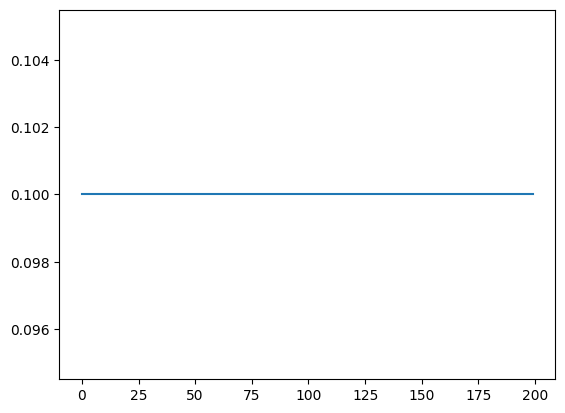

In [5]:
rendering_times = []
for lidar_frame in lidar_data:
    rendering_times.append(lidar_frame['rendering_time'])
plt.plot(np.diff(rendering_times))

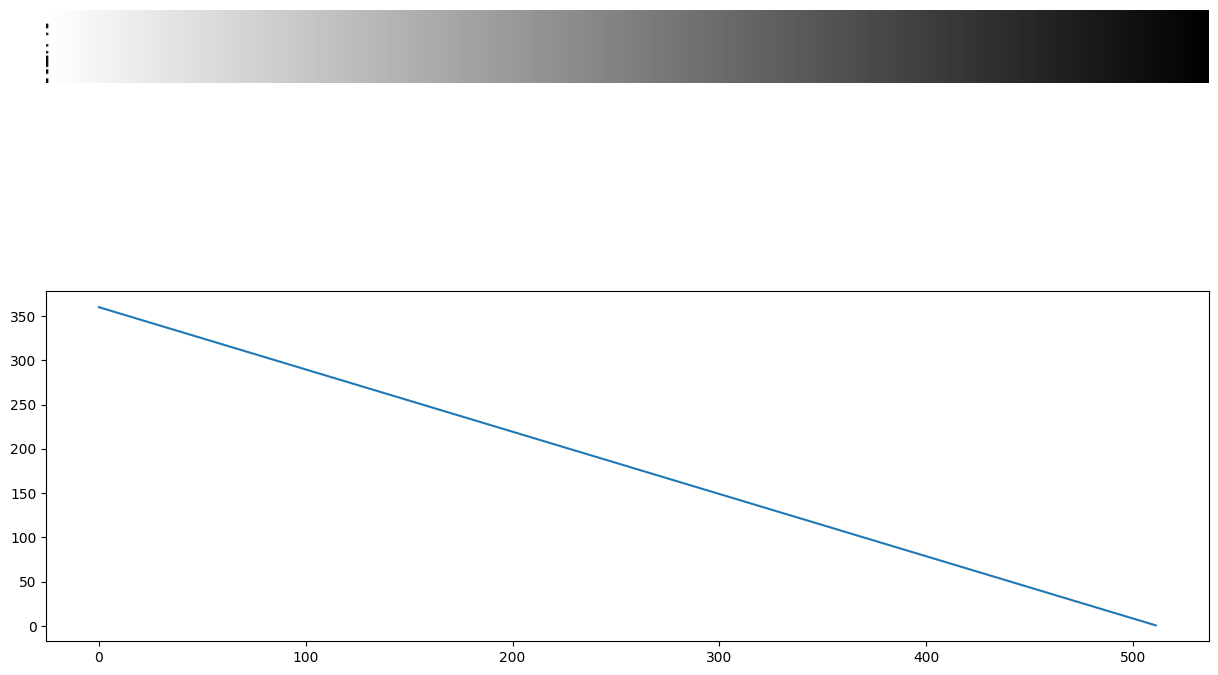

In [6]:
PI=np.pi
azi_offset = np.array([ 4.23, 1.41, -1.4, -4.21, 4.22, 1.42, -1.41, -4.22, 4.23, 1.41, -1.42, -4.21, 4.23, 1.42, -1.4, -4.2, 4.23, 1.41, -1.39, -4.21, 4.25, 1.43, -1.41, -4.22, 4.24, 1.44, -1.41, -4.22, 4.23, 1.42, -1.38, -4.22 ])
azimuths = lidar_data[5]['azimuths'].reshape(-1, 32, 2)[:,:,0].T
tick_azimuths = azimuths + azi_offset[:,None]
# tick_azimuths[tick_azimuths<-180] += 360
# tick_azimuths[tick_azimuths>=180] -= 360
tick_azimuths[tick_azimuths<0] += 360


fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].imshow(tick_azimuths, cmap='gray')
axs[0].axis('off')
axs[1].plot(tick_azimuths[0,:])

plt.show()



# Undistort point cloud

In [7]:
import noise

PI = np.pi

# make the lidar fly in a circle on xy plane
def make_circular_path(stepsPerSecond, duration, radius, angular_velocity=2*PI):
    t = np.arange(0, duration, 1.0/stepsPerSecond)
    yaw = angular_velocity * t
    pitch = np.zeros_like(yaw)
    roll = np.zeros_like(yaw)
    euler_xyz = np.array([roll, pitch, yaw]).T
    quats = np.array([euler_angles_to_quat(angles, degrees=False, extrinsic=True) for angles in euler_xyz])
    w, i, j, k = quats[:, 0], quats[:, 1], quats[:, 2], quats[:, 3]
    R = radius
    x = R * np.cos(yaw) * np.cos(pitch)
    y = R * np.sin(yaw) * np.cos(pitch)
    z = R * np.sin(pitch)
  
    return np.array([t, x, y, z, w, i, j, k]).T



In [8]:
def test():
    stage.create_new_stage()

    rendering_dt = 1.0/10
    physics_dt = 1.0/400
    T = 0.5
    trajectory_radius = 1
    angular_velocity = -4*PI #rad/s, same direction with lidar scan direction
    world = World(physics_dt=physics_dt, rendering_dt=rendering_dt)
    config = "OS1_REV6_32ch10hz512res_noiseless"
    lidar = RtxLidar('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
    # R = 10
    # sphere = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
    # sphere.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(R, R, R))
    W, H, D = 20, 20, 10
    cube = FixedCuboid('/TestNoise/Cube', position=[0, 0, 0])
    cube.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(W, H, D))

    world.scene.add(lidar)
    # world.scene.add(sphere)
    world.scene.add(cube)
    world.reset(soft=False)
    
    path = make_circular_path(int(1.0/physics_dt), T, trajectory_radius, angular_velocity)
    print(len(path))
    pi = iter(path)
    running = True
    def set_lidar_pose_cb(stepsize):
        nonlocal running
        try:
            p = next(pi)
            lidar.set_world_pose(p[1:4], p[4:])
        except StopIteration:
            running = False
            

    world.clear_physics_callbacks()
    world.add_physics_callback('set_lidar_pose', set_lidar_pose_cb)
    
    world.reset(soft=True)
    lidar_data = []
    def buffer_cb(frames):
        lidar_data.append(copy.deepcopy(frames))
    lidar.set_callback(buffer_cb)

    while(running):
        world.step()
    # for _ in range(20):
    #     world.step()
        
    world.stop()
    del lidar # to unsubscribe from event.. manually =.=
    return lidar_data, path

lidar_data, path = test()

skip empty frame
skip empty frame
skip empty frame
skip empty frame
200


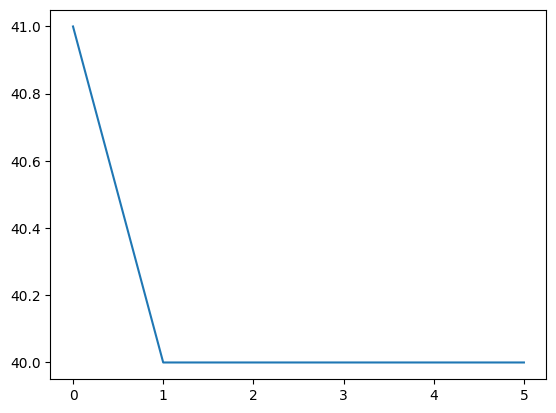

In [9]:
num_poses = [len(f['poses']) for f in lidar_data]
plt.plot(num_poses)

In [10]:
import rerun as rr
import numpy as np

rr.init("test_distort", spawn=True)

[2024-11-08T07:46:50Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-11-08T07:46:50Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-11-08T07:46:50Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:50050


[2024-11-08T07:46:50Z WARN  wgpu_hal::gles::egl] No config found!
[2024-11-08T07:46:50Z WARN  wgpu_hal::gles::egl] EGL says it can present to the window but not natively
[2024-11-08T07:46:50Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 12.0.0, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 21.2.6 (LLVM 12.0.0)", vendor: 0x10005}, {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA GeForce RTX 4060", driver: "NVIDIA", driver_info: "555.42.02", vendor: 0x10DE, device: 0x2882}, {backend: Gl, device_type: Other, name: "NVIDIA GeForce RTX 4060/PCIe/SSE2", driver: "OpenGL", driver_info: "4.6.0 NVIDIA 555.42.02", vendor: 0x10DE}


In [11]:

def Axes(l=1.0):
    return rr.Arrows3D(
        vectors=[[l, 0, 0], [0, l, 0], [0, 0, l]],
        colors=[[255,0,0], [0,255,0], [0,0,255]],
    )

def visualize_sim_lidar(frame, name, color=None):
    transform = np.array(frame['transform'])
    position = transform[:3,3]
    rotation = transform[:3,:3]
    quat = rot_matrix_to_quat(rotation)
    quat_xyzw = np.roll(quat, -1)
    
    rr.log(f'/world/distorted/{name}', rr.Transform3D(
        translation=position, quaternion=quat_xyzw))
    
    rr.log(f'/world/distorted/{name}', Axes(1.0))
    rr.log(f'/world/distorted/{name}/points', rr.Points3D(frame['xyz'], colors=color))

rr.set_time_seconds('sim_time', 0)
rr.log('/world', rr.Clear(recursive=True))
rr.log('/world', Axes(0.5), static=True)
trajectory = path[:, 1:4]
rr.log('/world/trajectory', rr.LineStrips3D(trajectory))

for i, scan in enumerate(lidar_data):
    visualize_sim_lidar(scan, f'scan_{i}')

In [12]:
from lidar import undistort, pose_to_transform, _to_sensor
    
def Axes(l=1.0):
    return rr.Arrows3D(
        vectors=[[l, 0, 0], [0, l, 0], [0, 0, l]],
        colors=[[255,0,0], [0,255,0], [0,0,255]],
    )

def visualize_sim_lidar_undistort(frame, name, color=None):
    p,q = frame['poses'][-1][1:]
    transform = pose_to_transform((p,q))
    pcd_undistort_world = undistort(frame['xyz'], frame['poses'])
    pcd_undistorted_sensor = _to_sensor(pcd_undistort_world, transform)
    
    rr.log(f'/world/undistorted/{name}', rr.Transform3D(
        translation=p, quaternion=wxyz2xyzw(q)))
    rr.log(f'/world/undistorted/{name}', Axes(1.0))
    rr.log(f'/world/undistorted/{name}/points_undistort', rr.Points3D(pcd_undistorted_sensor))


rr.log(f'/world/undistorted', rr.Clear(recursive=True))
for i, scan in enumerate(lidar_data):
    visualize_sim_lidar_undistort(scan, f'scan_{i}')

# Optimize the rendering time
- First set dt to a very small value. Check how long it take to simulate 1 second.
- Then disable the viewport and run again.

In [ ]:
stage.create_new_stage()

ticksPerSecond = lidar_info['ticksPerScan'] * 10 # =.=!
simulation_context = SimulationContext(
  physics_dt=1.0/ticksPerSecond,
  rendering_dt=1.0/ticksPerSecond
)

lidar = RtxLidarFullFrame("/TestNoise/Lidar", position=[0,0,0], config_file_name="OS1_REV6_32ch10hz512res")
wall = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
wall.prim.CreateAttribute('refinementEnableOverride', Sdf.ValueTypeNames.Bool).Set(True)
wall.prim.CreateAttribute('refinementLevel', Sdf.ValueTypeNames.Int).Set(5)

simulation_context.play()
for _ in range(ticksPerSecond):
  simulation_context.step()
simulation_context.stop()
  

In [ ]:
#changing the dt seems to reset things inside. So create the lidar again
stage.create_new_stage()

scansPerSecond = 10 # =.=!
ticksPerSecond = lidar_info['ticksPerScan'] * scansPerSecond
simulation_context = SimulationContext(
  physics_dt=1.0/ticksPerSecond,
  rendering_dt=1.0/ticksPerSecond
)

lidar = RtxLidarFullFrame("/TestNoise/Lidar", position=[0,0,0], config_file_name="OS1_REV6_32ch10hz512res")
wall = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
wall.prim.CreateAttribute('refinementEnableOverride', Sdf.ValueTypeNames.Bool).Set(True)
wall.prim.CreateAttribute('refinementLevel', Sdf.ValueTypeNames.Int).Set(5)

# set the viewport to the lidar camera, so that it render nothing. Is there any other way?
vp_window = get_window_from_id('Viewport/Viewport0')
omni.kit.commands.execute(
    "SetViewportCamera", camera_path='/TestNoise/Lidar', viewport_api=vp_window.viewport_api
)

lidar_rotate_dt = 1.0 / scansPerSecond
next_lidar_ready = lidar_rotate_dt

simulation_context.play()
data = []
for _ in range(ticksPerSecond):
  simulation_context.step()
  timestamp = simulation_context.current_time
  if timestamp > next_lidar_ready:
    data.append(deep_copy(lidar.get_current_frame()))
    next_lidar_ready += lidar_rotate_dt
    
simulation_context.stop()

### disable viewport rendering reduce runtime from 103s to 71s (~30%)